In [1]:
import pandas as pd
from pysam import VariantFile
import glob
import seaborn as sns
from matplotlib import pyplot as plt

# download pileup from ANVIL

In [2]:
sample_df = pd.read_csv('sample (12).tsv',sep='\t')


In [80]:
sample_cols = sample_df.columns[sample_df.columns=='Esophagus_Muscularis_MAX']

In [81]:
sample_cols

Index(['Esophagus_Muscularis_MAX'], dtype='object')

In [82]:
for sample_col in sample_cols:
    tissue_df = sample_df.loc[~sample_df[sample_col].isna(),['participant','tissue_id',sample_col]].copy()
    with open(f'../topmed_telomere_validation/rename_{sample_col}.sh','w') as handle:
        for i,r in tissue_df.iterrows():
            handle.write(f"cp {sample_col}.{r.participant}.tsv {r['tissue_id']}_rs4902358.{r.participant}.tsv\n")

In [8]:
for sample_col in sample_cols:
    tissue_df = sample_df.loc[~sample_df[sample_col].isna(),['participant','tissue_id',sample_col]].copy()
    with open(f'../topmed_telomere_validation/download_piles_{sample_col}.sh','w') as handle:
        handle.write('#!/bin/bash\n# ---------------------------------------------------\n')
        handle.write('# The Advanced Research Computing at Hopkins (ARCH)\n')
        handle.write('# User and Application Support < help@rockfish.jhu.edu >\n')
        handle.write('#\n')
        handle.write('# SLURM script to run the JupyterLab\n')
        handle.write('#\n')
        handle.write('# ---------------------------------------------------\n')
        handle.write('#  INPUT ENVIRONMENT VARIABLES\n')
        handle.write('# ---------------------------------------------------\n')
        handle.write('#SBATCH --job-name=WtsdSV\n')
        handle.write('#SBATCH --time=3:0:0\n')
        handle.write('#SBATCH --partition=defq\n')
        handle.write('#SBATCH -A mschatz1\n')
        handle.write('#SBATCH --mem=8G\n')
        handle.write('#SBATCH --signal=USR2\n')
        handle.write('#SBATCH --nodes=1\n')
        handle.write('#SBATCH --cpus-per-task=4\n')
        handle.write('#SBATCH --mail-type=END,FAIL\n')
        handle.write('#SBATCH --mail-user=bni1@jhu.edu\n')
        handle.write('#SBATCH --output=TopmedPlot.job.%j.out\n')
        handle.write('#SBATCH --erro=TopmedPlot.job.%j.err\n')
        handle.write('# ---------------------------------------------------\n')
        handle.write('module load anaconda\n')
        handle.write('conda activate rare_variants\n')
        for i,r in tissue_df.iterrows():
            handle.write(f"gsutil cp {r[sample_col]} {sample_col}.{r.participant}.tsv\n")

# reading in the coordinates and info for plot.

In [84]:
snv_info = pd.read_csv('pileup_plots_index_v3 (1).csv')
snv_info.loc[0,'tissue'] = 'lung'
snv_info[['chr', 'hg38', 'ref', 'alt']] = snv_info['chr:hg38:ref:alt'].str.split(':',expand=True)

## plot each example. 

analyzing rs3775946
processed dna
processed RNA
9941910,9942050
9980590,9980740
9985665,9985795
9996775,9996945
saved fig


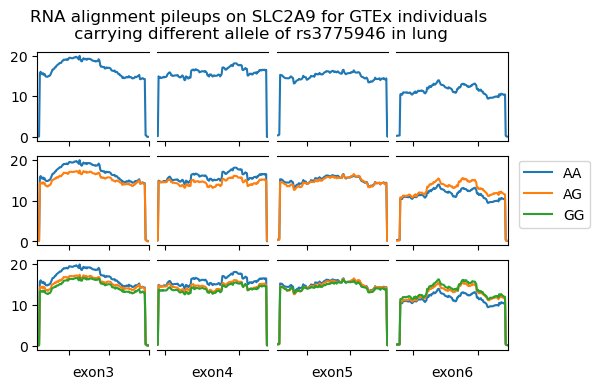

analyzing rs4691895
processed dna
processed RNA
163148338,163148450
163164200,163164400
163166350,163166895
saved fig


<Figure size 640x480 with 0 Axes>

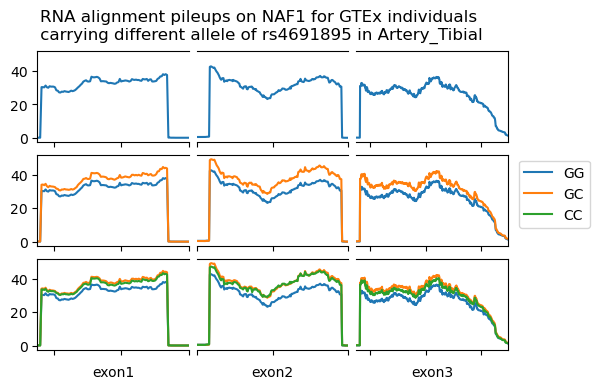

analyzing rs62560860
processed dna
processed RNA
34660850,34660940
34661475,34661905
saved fig


<Figure size 640x480 with 0 Axes>

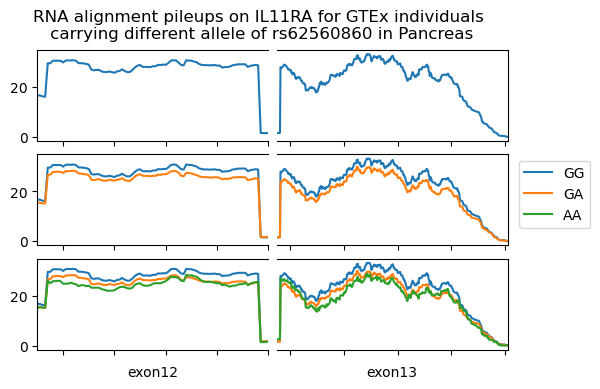

analyzing rs12934863
processed dna
processed RNA
68054444,68054620
68056360,68056425
68061060,68061171
saved fig


<Figure size 640x480 with 0 Axes>

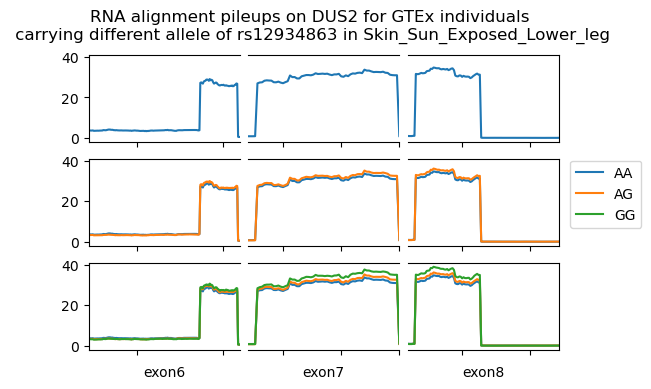

analyzing rs6564996
processed dna
processed RNA
82148082,82148870
82149300,82149420
82151420,82151520
82164050,82164776
saved fig


<Figure size 640x480 with 0 Axes>

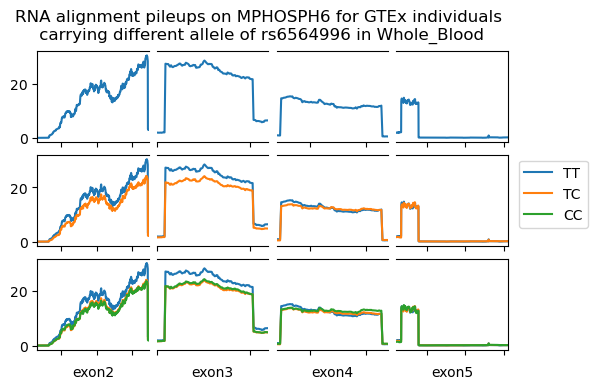

analyzing rs131784
processed dna
processed RNA
50525739,50525920
50525995,50526160
50526240,50526480
50526570,50526750
saved fig


<Figure size 640x480 with 0 Axes>

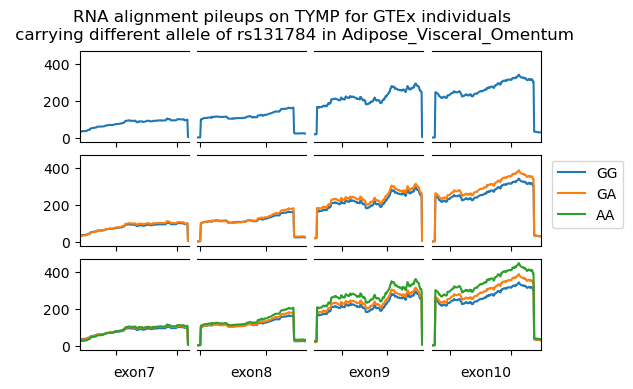

analyzing rs4902358
processed dna
processed RNA
65076393,65076665
65077340,65077430
65077910,65078040
65093705,65093820
65101540,65101575
65102300,65102543
saved fig


<Figure size 640x480 with 0 Axes>

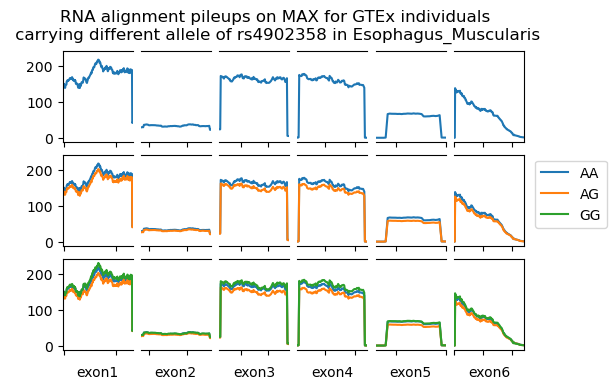

analyzing rs59922886
processed dna
processed RNA
8234428,8234660
8234740,8234930
8235050,8235290
8235825,8235965
8236055,8236381
saved fig


<Figure size 640x480 with 0 Axes>

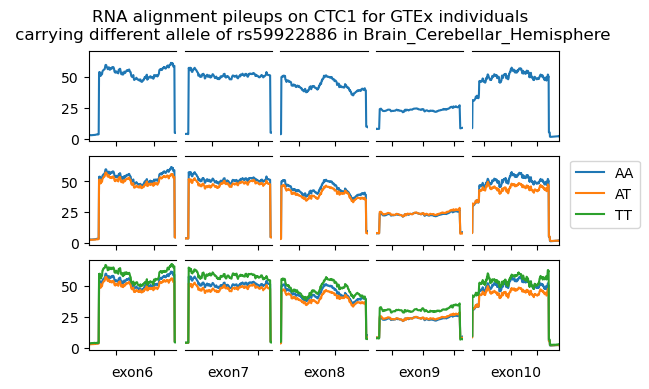

<Figure size 640x480 with 0 Axes>

In [85]:
for i,r in snv_info.iterrows():
    # first we get genotype. 
    snpid = f'chr{r["chr"]}_{r["hg38"]}_{r["ref"]}_{r["alt"]}_b38'
    print(f'analyzing {r["rsid"]}')
    with VariantFile('/scratch16/abattle4/lab_data/GTEx_v8/genotypes_5_22/GTEx_Analysis_2017-06-05_v8_WholeGenomeSeq_838Indiv_Analysis_Freeze.vcf.gz')as variants:
        samples = list(variants.header.samples)
        for variant in variants.fetch(f'chr{r["chr"]}',int(r["hg38"])-1,int(r["hg38"])+1):
            if variant.id == snpid:
                pop_entry = list(map(variant.samples.get,samples))
    ref = f'{r["ref"]}{r["ref"]}'
    hetalt = f'{r["ref"]}{r["alt"]}'
    homalt = f'{r["alt"]}{r["alt"]}'
    gt_dict = {(0,0):ref,(0,1):hetalt,(1,1):homalt,(None,None):-1}
    alleles = [gt_dict[i['GT']] for i in pop_entry]
    GT_df = pd.DataFrame({'SubjectID':samples,'Allele':alleles})
    cleaned_GT_df = GT_df[GT_df.Allele!=-1]
    print('processed dna')
    
    # now do rna
    dfs = []
    for i in glob.glob(f'../topmed_telomere_validation/{r["tissue"]}_{r["rsid"]}.*'):
        subjectID = i.split('/')[-1].split('.')[1]
        depth = pd.read_csv(i,sep='\t',header=None,names=['chrom','pos','coverage'])
        depth['SubjectID'] = subjectID
        dfs.append(depth)
    all_depth = pd.concat(dfs)

    all_depth_with_gt = all_depth.merge(cleaned_GT_df,on='SubjectID')

    stats_per_base = all_depth_with_gt.drop(['SubjectID','chrom'],axis=1).groupby(['Allele','pos']).agg(['mean','std']).reset_index()

    stats_per_base.columns = ['Allele','position','mean depth','standard deviation depth']
    print('processed RNA')
    
    # get how many split to make in x axis. 
    first_exon,last_exon = [int(k) for k in r['exons_included'].split('exon')[1].split('-')]
    # label for exon numbers. 
    subplot_titles = [f'exon{k}' for k in range(first_exon,last_exon+1)]
    f, axes = plt.subplots(3, len(subplot_titles), 
                           figsize=(5.06,3.78),
                           constrained_layout=True,
                           sharey=True, 
                           facecolor='w')
    f.suptitle(f'RNA alignment pileups on {r["hgnc"]} for GTEx individuals\n carrying different allele of {r["rsid"]} in {r["tissue"]}')

    # now get rna. 
    counter_exon = 0
    hom_ref_stats = stats_per_base[stats_per_base['Allele']==ref]
    het_alt_stats = stats_per_base[stats_per_base['Allele']==hetalt]
    hom_alt_stats = stats_per_base[stats_per_base['Allele']==homalt]

    for j in r['subset_plot_coordinates'].split(','):
        # we want each exon's coordinate, and make a subplot for that. 
        subplot_start,subplot_end = [int(k) for k in j.split('-')]
        print(f'{subplot_start},{subplot_end}')
        # adopted from matplotlib split x axis tutorial
        # plot the same data on both axes
        # make sure left spine displayed for first exon:
        show_left_spine = False
        if counter_exon==0:
            show_left_spine = True
        # make sure right spine displayed for last exon:
        shwo_right_spine = False
        if counter_exon==len(subplot_titles)-1:
            shwo_right_spine = True
        #ax.yaxis.tick_left()
        #ax.tick_params(labelright='off')
        #ax2.yaxis.tick_right()
        
        # first, hom_ref
        axes[0,counter_exon].plot(hom_ref_stats['position'],hom_ref_stats['mean depth'],label=ref if counter_exon==0 else '')
        axes[0,counter_exon].set_xlim(subplot_start, subplot_end)
        axes[0,counter_exon].spines['right'].set_visible(shwo_right_spine)
        axes[0,counter_exon].spines['left'].set_visible(show_left_spine)
        axes[0,counter_exon].get_yaxis().set_visible(show_left_spine)
        axes[0,counter_exon].set_xticklabels([])
        # then, hom_ref, het_alt
        axes[1,counter_exon].plot(hom_ref_stats['position'],hom_ref_stats['mean depth'])
        axes[1,counter_exon].set_xlim(subplot_start, subplot_end)
        axes[1,counter_exon].plot(het_alt_stats['position'],het_alt_stats['mean depth'],label=hetalt if counter_exon==0 else '')
        axes[1,counter_exon].set_xlim(subplot_start, subplot_end)
        axes[1,counter_exon].spines['right'].set_visible(shwo_right_spine)
        axes[1,counter_exon].spines['left'].set_visible(show_left_spine)
        axes[1,counter_exon].get_yaxis().set_visible(show_left_spine)
        axes[1,counter_exon].set_xticklabels([])
        # then, hom_ref, het_alt, hom_alt
        axes[2,counter_exon].plot(hom_ref_stats['position'],hom_ref_stats['mean depth'])
        axes[2,counter_exon].set_xlim(subplot_start, subplot_end)
        axes[2,counter_exon].plot(het_alt_stats['position'],het_alt_stats['mean depth'])
        axes[2,counter_exon].set_xlim(subplot_start, subplot_end)
        axes[2,counter_exon].plot(hom_alt_stats['position'],hom_alt_stats['mean depth'],label=homalt if counter_exon==0 else '')
        axes[2,counter_exon].set_xlim(subplot_start, subplot_end)
        axes[2,counter_exon].spines['right'].set_visible(shwo_right_spine)
        axes[2,counter_exon].spines['left'].set_visible(show_left_spine)
        axes[2,counter_exon].get_yaxis().set_visible(show_left_spine)
        axes[2,counter_exon].set_xticklabels([])
        axes[2,counter_exon].set_xlabel(subplot_titles[counter_exon])
        #last: 
        counter_exon +=1
    f.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ylabel('coverage')
    plt.gcf().set_size_inches(5.06, 3.78)
    plt.savefig(f'{r["tissue"]}_{r["rsid"]}.png',bbox_inches='tight')
    print('saved fig')
    plt.show()
    plt.clf()